In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [242]:
train = pd.read_csv('Train.csv')
train.head()

,Average_Annual_Salary,Jobs_Openings,Future_Jobs_Openings,Remote_jobs,Job_Automation_Risk
0,132765.81730,2661.913845,7738.246377,58.641828,53.6896
1,95964.95157,9874.229809,-710.691728,33.038335,46.9004
2,108850.83040,4832.616502,8374.008305,22.423622,49.2622
3,91959.51280,8105.311846,3611.026858,43.400424,54.7329
4,39892.72663,3570.443047,2013.048226,19.311998,45.9295


In [243]:
train.shape

(14693, 5)

In [244]:
train.isnull().sum()

Average_Annual_Salary    0
Jobs_Openings            0
Future_Jobs_Openings     0
Remote_jobs              0
Job_Automation_Risk      0
dtype: int64

In [245]:
train.duplicated().sum()

0

In [246]:
train.describe()

,Average_Annual_Salary,Jobs_Openings,Future_Jobs_Openings,Remote_jobs,Job_Automation_Risk
count,14693.000000,14693.000000,14693.000000,14693.000000,14693.000000
mean,90189.954942,5001.857760,5102.520267,49.908559,48.241133
std,34327.502897,2867.505535,2887.476914,29.318981,7.324832
min,-31701.699680,-5009.146921,-4844.594764,-54.177936,21.523100
25%,66866.392160,2794.982742,2741.940162,27.929160,43.244600
50%,90103.048310,5020.501139,5149.666714,49.418906,48.158200
75%,113381.813900,7162.651693,7528.891014,72.669261,53.254400
max,225222.459200,15833.731050,13400.080210,175.909001,72.832600


In [247]:
test = pd.read_csv('Test.csv')
test.head()

,Average_Annual_Salary,Jobs_Openings,Future_Jobs_Openings,Remote_jobs,Job_Automation_Risk
0,129991.59170,6860.824385,8752.658731,72.825007,NaN
1,121709.45190,5107.802072,4444.963829,34.799589,NaN
2,85724.71504,6393.961718,1772.444794,30.880178,NaN
3,134009.49720,3473.587654,4404.329572,75.339995,NaN
4,115715.75970,6196.493115,7634.733745,40.388451,NaN


In [248]:
test.shape

(200, 5)

In [249]:
test.isnull().sum()

Average_Annual_Salary      0
Jobs_Openings              0
Future_Jobs_Openings       0
Remote_jobs                0
Job_Automation_Risk      200
dtype: int64

In [250]:
test.duplicated().sum()

0

In [251]:
combined = pd.concat([train, test], axis = 0)
combined.shape

(14893, 5)

In [252]:
combined["Future_Job_Growth"] = (combined["Future_Jobs_Openings"] - combined["Jobs_Openings"]) / combined["Jobs_Openings"]

In [253]:
combined["Salary_per_Current_Opening"] = combined["Average_Annual_Salary"] / combined["Jobs_Openings"]

In [254]:
combined["Salary_per_Future_Opening"] = combined["Average_Annual_Salary"] / (combined["Jobs_Openings"] + combined["Future_Jobs_Openings"])

In [255]:
combined["Remote_Job_Ratio"] = combined["Remote_jobs"] / combined["Jobs_Openings"]

In [256]:
combined["Absolute_Future_Change"] = combined["Future_Jobs_Openings"] - combined["Jobs_Openings"]

In [257]:
combined["Log_Salary"] = np.log(combined["Average_Annual_Salary"].clip(lower=1))

In [258]:
combined["Growth_Flag"] = (combined["Future_Jobs_Openings"] > combined["Jobs_Openings"]).astype(int)

In [259]:
combined.head()

,Average_Annual_Salary,Jobs_Openings,Future_Jobs_Openings,Remote_jobs,Job_Automation_Risk,Future_Job_Growth,Salary_per_Current_Opening,Salary_per_Future_Opening,Remote_Job_Ratio,Absolute_Future_Change,Log_Salary,Growth_Flag
0,132765.81730,2661.913845,7738.246377,58.641828,53.6896,1.907024,49.876076,12.765747,0.022030,5076.332532,11.796342,1
1,95964.95157,9874.229809,-710.691728,33.038335,46.9004,-1.071974,9.718728,10.472478,0.003346,-10584.921537,11.471738,0
2,108850.83040,4832.616502,8374.008305,22.423622,49.2622,0.732810,22.524202,8.242138,0.004640,3541.391803,11.597734,1
3,91959.51280,8105.311846,3611.026858,43.400424,54.7329,-0.554486,11.345586,7.848827,0.005355,-4494.284988,11.429104,0
4,39892.72663,3570.443047,2013.048226,19.311998,45.9295,-0.436191,11.173047,7.144764,0.005409,-1557.394821,10.593949,0


In [260]:
correlation_matrix = combined.corr()
target_corr = correlation_matrix["Job_Automation_Risk"].sort_values(ascending=False)
print(target_corr)

Job_Automation_Risk           1.000000
Growth_Flag                   0.136419
Absolute_Future_Change        0.124552
Future_Jobs_Openings          0.107872
Average_Annual_Salary         0.010727
Salary_per_Current_Opening    0.004096
Salary_per_Future_Opening     0.000990
Remote_Job_Ratio              0.000971
Future_Job_Growth            -0.003183
Log_Salary                   -0.024081
Remote_jobs                  -0.039917
Jobs_Openings                -0.068628
Name: Job_Automation_Risk, dtype: float64


In [261]:
combined.isnull().sum()

Average_Annual_Salary           0
Jobs_Openings                   0
Future_Jobs_Openings            0
Remote_jobs                     0
Job_Automation_Risk           200
Future_Job_Growth               0
Salary_per_Current_Opening      0
Salary_per_Future_Opening       0
Remote_Job_Ratio                0
Absolute_Future_Change          0
Log_Salary                      0
Growth_Flag                     0
dtype: int64

In [262]:
newtrain = combined.iloc[0:14693, :]
newtest = combined.iloc[14693:, :].drop('Job_Automation_Risk', axis = 1)

In [263]:
newtrain.shape

(14693, 12)

In [264]:
newtest.shape

(200, 11)

In [265]:
x = newtrain.drop('Job_Automation_Risk', axis = 1)
y = newtrain['Job_Automation_Risk']

In [266]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [267]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [268]:
models = {'Linear Regression': LinearRegression(), 'Random Forest': RandomForestRegressor(),
         'Bagging': BaggingRegressor(), 'Extra Tree': ExtraTreesRegressor(), 'LightGBM': LGBMRegressor(),
         'Gradient Boosting': GradientBoostingRegressor(), 'Adaboost': AdaBoostRegressor(), 'Ridge': Ridge(), 'Lasso': Lasso(),
         'XGB': XGBRegressor()}

In [269]:
def evaluate_models(x_train, x_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        predictions = model.fit(x_train, y_train).predict(x_test)
        accuracy = np.sqrt(mean_squared_error(y_test, predictions))
        results[name] = accuracy
    return results

In [270]:
results = evaluate_models(x_train, x_test, y_train, y_test, models)

C:\Users\ahpat\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ahpat\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2553
[LightGBM] [Info] Number of data points in the train set: 11754, number of used features: 11
[LightGBM] [Info] Start training from score 48.232733


In [271]:
best_model_name = min(results, key = results.get)
best_model = models[best_model_name]

In [272]:
print(f"best model is {best_model_name} with rmse {results[best_model_name]}")

best model is LightGBM with rmse 5.796982638132602


In [273]:
y_pred = best_model.fit(x_train, y_train).predict(x_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2553
[LightGBM] [Info] Number of data points in the train set: 11754, number of used features: 11
[LightGBM] [Info] Start training from score 48.232733


C:\Users\ahpat\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ahpat\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [274]:
print(np.sqrt(mean_squared_error(y_test, y_pred)))

5.796982638132602


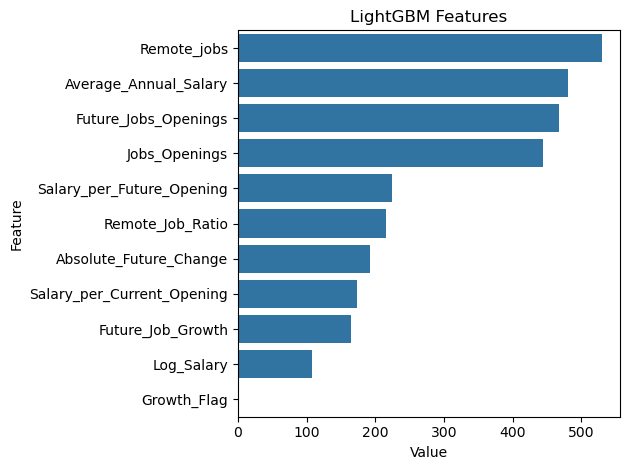

In [309]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, x.columns), reverse=True)[:20], columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title(f'{best_model_name} Features')
plt.tight_layout()
plt.show()

In [311]:
x_train = newtrain.drop('Job_Automation_Risk', axis = 1)
y_train = newtrain['Job_Automation_Risk']
x_test = newtest
y_pred = best_model.fit(x_train, y_train).predict(x_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 14693, number of used features: 11
[LightGBM] [Info] Start training from score 48.241133


In [313]:
solution = pd.DataFrame({'Job_Automation_Risk': y_pred})
solution.head()

,Job_Automation_Risk
0,46.039198
1,41.802341
2,51.449330
3,50.239339
4,43.845809


In [317]:
x_train = newtrain.drop(['Job_Automation_Risk','Growth_Flag'], axis = 1)
y_train = newtrain['Job_Automation_Risk']
x_test = newtest.drop('Growth_Flag', axis = 1)
y_pred = best_model.fit(x_train, y_train).predict(x_test)
solution = pd.DataFrame({'Job_Automation_Risk': y_pred})
solution.to_csv('Last.csv', index = False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 14693, number of used features: 10
[LightGBM] [Info] Start training from score 48.241133


In [315]:
solution.to_csv('Solution.csv', index = False)